
# Loan Approval Prediction


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import numpy as np
import sklearn as skl
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

train_df = pd.read_csv('train.csv')
print(train_df.columns.values, train_df.shape)
train_df['loan_status'] = 1 - train_df['loan_status']

['id' 'person_age' 'person_income' 'person_home_ownership'
 'person_emp_length' 'loan_intent' 'loan_grade' 'loan_amnt'
 'loan_int_rate' 'loan_percent_income' 'cb_person_default_on_file'
 'cb_person_cred_hist_length' 'loan_status'] (58645, 13)


In [27]:
# first lets check how many features have missing data and what percentage
# lets divide features into categorical and continuous values
# Categorical features: home ownerhsip, loan intent, loan grade, cb_person_default_on_file
# Continuous features: age, income, emp length, loan amount, cb_cred_hist_length, loan_int_rate, loan_per_income

# lets check missing values on categorical 
def check_missing_cat_values(col):
    missing_or_empty =(((train_df[col].isna()) | (train_df[col] == '') | (train_df[col] == None)).sum())/len(train_df[col])
    print(f'missing_or_empty for {col}: {missing_or_empty*100} and total number: {len(train_df[col])}')

check_missing_cat_values('person_home_ownership')
check_missing_cat_values('loan_intent')
check_missing_cat_values('loan_grade')
check_missing_cat_values('cb_person_default_on_file')

# lets check missing values on continuous 
def check_missing_cont_values(col):
    missing_or_empty =(((train_df[col].isna()) | (train_df[col] == 0)).sum())/len(train_df[col])
    print(f'missing_or_empty for {col}: {missing_or_empty*100} and total number: {len(train_df[col])}')

check_missing_cont_values('person_age')
check_missing_cont_values('person_income')
check_missing_cont_values('person_emp_length')
check_missing_cont_values('loan_amnt')
check_missing_cont_values('cb_person_cred_hist_length')
check_missing_cont_values('loan_int_rate')
check_missing_cont_values('loan_percent_income')

missing_or_empty for person_home_ownership: 0.0 and total number: 58645
missing_or_empty for loan_intent: 0.0 and total number: 58645
missing_or_empty for loan_grade: 0.0 and total number: 58645
missing_or_empty for cb_person_default_on_file: 0.0 and total number: 58645
missing_or_empty for person_age: 0.0 and total number: 58645
missing_or_empty for person_income: 0.0 and total number: 58645
missing_or_empty for person_emp_length: 12.935459118424419 and total number: 58645
missing_or_empty for loan_amnt: 0.0 and total number: 58645
missing_or_empty for cb_person_cred_hist_length: 0.0 and total number: 58645
missing_or_empty for loan_int_rate: 0.0 and total number: 58645
missing_or_empty for loan_percent_income: 0.0034103504135049876 and total number: 58645


In [28]:
# lets visualize categorical values 
# lets check loan approve rate in each category

result_loan_intent = train_df.groupby('loan_intent')['loan_status'].value_counts(normalize=True).rename('percentage_loan_intent').reset_index()
print(result_loan_intent)
print(result_loan_intent[result_loan_intent['loan_status'] == 1])

result_person_home_ownership = train_df.groupby('person_home_ownership')['loan_status'].value_counts(normalize=True).rename('percentage_person_home_ownership').reset_index()
print(result_person_home_ownership)
print(result_person_home_ownership[result_person_home_ownership['loan_status'] == 1])

result_loan_grade = train_df.groupby('loan_grade')['loan_status'].value_counts(normalize=True).rename('percentage_loan_grade').reset_index()
print(result_loan_grade)
print(result_loan_grade[result_loan_grade['loan_status'] == 1])

result_cb_person_default_on_file = train_df.groupby('cb_person_default_on_file')['loan_status'].value_counts(normalize=True).rename('percentage_cb_person_default_on_file').reset_index()
print(result_cb_person_default_on_file)
print(result_cb_person_default_on_file[result_cb_person_default_on_file['loan_status'] == 1])


          loan_intent  loan_status  percentage_loan_intent
0   DEBTCONSOLIDATION            1                0.810687
1   DEBTCONSOLIDATION            0                0.189313
2           EDUCATION            1                0.892266
3           EDUCATION            0                0.107734
4     HOMEIMPROVEMENT            1                0.826274
5     HOMEIMPROVEMENT            0                0.173726
6             MEDICAL            1                0.821749
7             MEDICAL            0                0.178251
8            PERSONAL            1                0.867212
9            PERSONAL            0                0.132788
10            VENTURE            1                0.907202
11            VENTURE            0                0.092798
          loan_intent  loan_status  percentage_loan_intent
0   DEBTCONSOLIDATION            1                0.810687
2           EDUCATION            1                0.892266
4     HOMEIMPROVEMENT            1                0.8262

In [29]:
# lets visualize categorical values 
# lets check loan approve rate proportions by category

approve_df = train_df[train_df['loan_status']==1]
result_loan_intent = approve_df['loan_intent'].value_counts(normalize=True)
print(result_loan_intent)

result_person_home_ownership = approve_df['person_home_ownership'].value_counts(normalize=True)
print(result_person_home_ownership)

result_loan_grade = approve_df['loan_grade'].value_counts(normalize=True)
print(result_loan_grade)

result_cb_person_default_on_file = approve_df['cb_person_default_on_file'].value_counts(normalize=True)
print(result_cb_person_default_on_file)

loan_intent
EDUCATION            0.217696
VENTURE              0.180575
MEDICAL              0.178646
PERSONAL             0.172701
DEBTCONSOLIDATION    0.147211
HOMEIMPROVEMENT      0.103171
Name: proportion, dtype: float64
person_home_ownership
RENT        0.472910
MORTGAGE    0.464082
OWN         0.061537
OTHER       0.001471
Name: proportion, dtype: float64
loan_grade
A    0.396699
B    0.364112
C    0.189721
D    0.040680
E    0.007516
F    0.001153
G    0.000119
Name: proportion, dtype: float64
cb_person_default_on_file
N    0.878696
Y    0.121304
Name: proportion, dtype: float64


In [30]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  # Bias correction
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


cramers_v_score = cramers_v(train_df['person_home_ownership'], train_df['loan_status'])
print(f"Cramér’s V for person_home_ownership : {cramers_v_score:.4f}")
cramers_v_score = cramers_v(train_df['loan_intent'], train_df['loan_status'])
print(f"Cramér’s V for loan_intent: {cramers_v_score:.4f}")
cramers_v_score = cramers_v(train_df['loan_grade'], train_df['loan_status'])
print(f"Cramér’s V for loan_grade: {cramers_v_score:.4f}")
cramers_v_score = cramers_v(train_df['cb_person_default_on_file'], train_df['loan_status'])
print(f"Cramér’s V for cb_person_default_on_file: {cramers_v_score:.4f}")

Cramér’s V for person_home_ownership : 0.2416
Cramér’s V for loan_intent: 0.1057
Cramér’s V for loan_grade: 0.4611
Cramér’s V for cb_person_default_on_file: 0.1868


In [31]:
check_missing_cont_values('loan_status')

missing_or_empty for loan_status: 14.238212976383323 and total number: 58645


In [32]:
# Get min and max values for each Continuous feature
def get_min_max(col):
    print(f"Minimum value of {col}: {min(train_df[col])} and maximum value of {col}: {max(train_df[col])}")

get_min_max('person_age')
get_min_max('person_income')
get_min_max('person_emp_length')
get_min_max('loan_amnt')
get_min_max('cb_person_cred_hist_length')
get_min_max('loan_int_rate')
get_min_max('loan_percent_income')


Minimum value of person_age: 20 and maximum value of person_age: 123
Minimum value of person_income: 4200 and maximum value of person_income: 1900000
Minimum value of person_emp_length: 0.0 and maximum value of person_emp_length: 123.0
Minimum value of loan_amnt: 500 and maximum value of loan_amnt: 35000
Minimum value of cb_person_cred_hist_length: 2 and maximum value of cb_person_cred_hist_length: 30
Minimum value of loan_int_rate: 5.42 and maximum value of loan_int_rate: 23.22
Minimum value of loan_percent_income: 0.0 and maximum value of loan_percent_income: 0.83


In [33]:
# let calculate median for all continuous features
median = train_df['person_age'].median()
print(f"Median for person_age: {median}")
median = train_df['person_income'].median()
print(f"Median for person_income: {median}")
median = train_df['person_emp_length'].median()
print(f"Median for person_emp_length: {median}")
median = train_df['loan_amnt'].median()
print(f"Median for loan_amnt: {median}")
median = train_df['cb_person_cred_hist_length'].median()
print(f"Median for cb_person_cred_hist_length: {median}")
median = train_df['loan_int_rate'].median()
print(f"Median for loan_int_rate: {median}")
median = train_df['loan_percent_income'].median()
print(f"Median for loan_percent_income: {median}")

Median for person_age: 26.0
Median for person_income: 58000.0
Median for person_emp_length: 4.0
Median for loan_amnt: 8000.0
Median for cb_person_cred_hist_length: 4.0
Median for loan_int_rate: 10.75
Median for loan_percent_income: 0.14


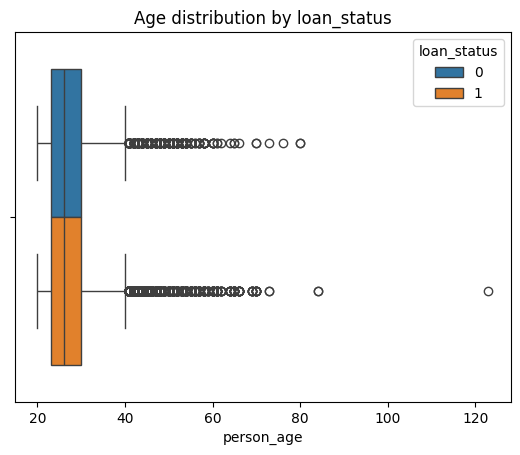

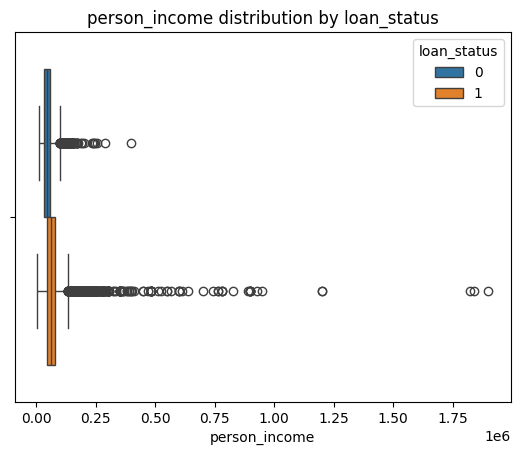

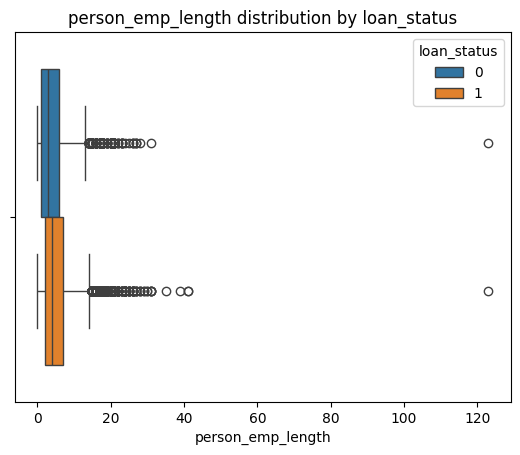

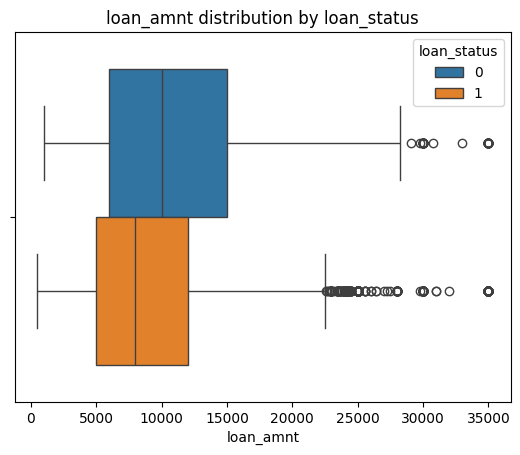

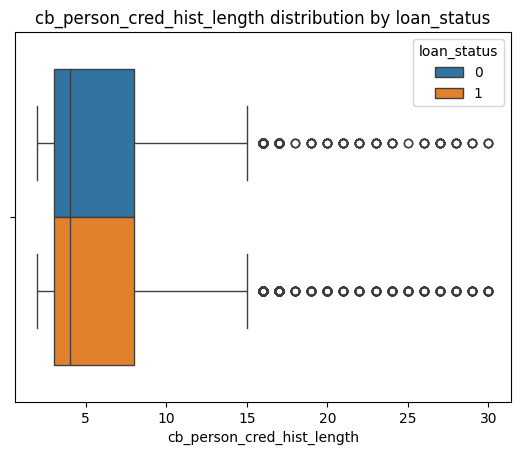

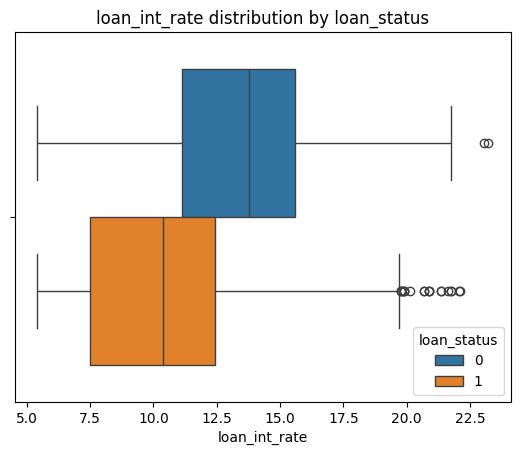

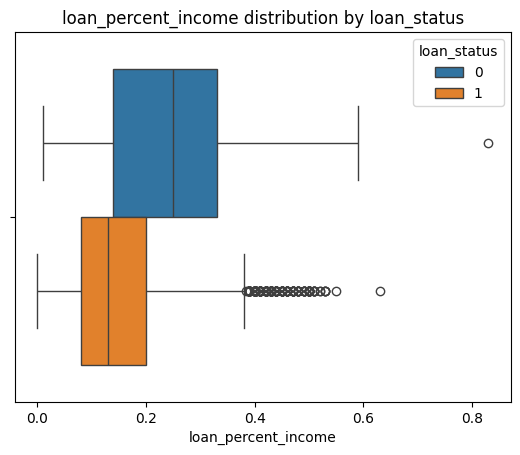

In [34]:
# lets visualize continuous values 
sns.boxplot(data=train_df, x='person_age', hue='loan_status')
plt.title("Age distribution by loan_status")
plt.show()

sns.boxplot(data=train_df, x='person_income', hue='loan_status')
plt.title("person_income distribution by loan_status")
plt.show()

sns.boxplot(data=train_df, x='person_emp_length', hue='loan_status')
plt.title("person_emp_length distribution by loan_status")
plt.show()

sns.boxplot(data=train_df, x='loan_amnt', hue='loan_status')
plt.title("loan_amnt distribution by loan_status")
plt.show()

sns.boxplot(data=train_df, x='cb_person_cred_hist_length', hue='loan_status')
plt.title("cb_person_cred_hist_length distribution by loan_status")
plt.show()

sns.boxplot(data=train_df, x='loan_int_rate', hue='loan_status')
plt.title("loan_int_rate distribution by loan_status")
plt.show()

sns.boxplot(data=train_df, x='loan_percent_income', hue='loan_status')
plt.title("loan_percent_income distribution by loan_status")
plt.show()


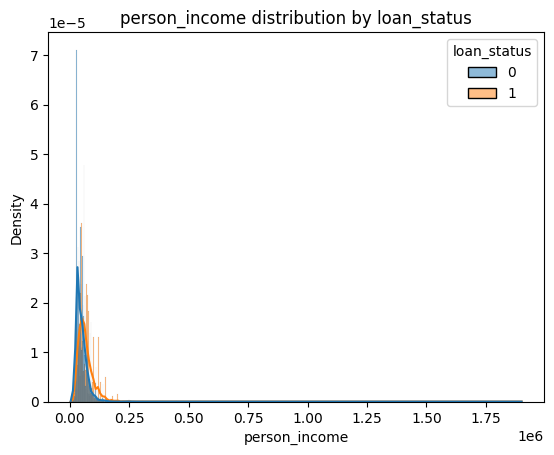

In [35]:
# # lets visualize continuous values 
# sns.histplot(data=train_df, x='person_age', hue='loan_status', kde=True, stat="density", common_norm=False)
# plt.title("Age distribution by loan_status")
# plt.show()

sns.histplot(data=train_df, x='person_income', hue='loan_status', kde=True, stat="density", common_norm=False)
plt.title("person_income distribution by loan_status")
plt.show()

# sns.histplot(data=train_df, x='person_emp_length', hue='loan_status', kde=True, stat="density", common_norm=False)
# plt.title("person_emp_length distribution by loan_status")
# plt.show()

# sns.histplot(data=train_df, x='loan_amnt', hue='loan_status', kde=True, stat="density", common_norm=False)
# plt.title("loan_amnt distribution by loan_status")
# plt.show()

# sns.histplot(data=train_df, x='cb_person_cred_hist_length', hue='loan_status', kde=True, stat="density", common_norm=False)
# plt.title("cb_person_cred_hist_length distribution by loan_status")
# plt.show()

# sns.histplot(data=train_df, x='loan_int_rate', hue='loan_status', kde=True, stat="density", common_norm=False)
# plt.title("loan_int_rate distribution by loan_status")
# plt.show()

# sns.histplot(data=train_df, x='loan_percent_income', hue='loan_status', kde=True, stat="density", common_norm=False)
# plt.title("loan_percent_income distribution by loan_status")
# plt.show()

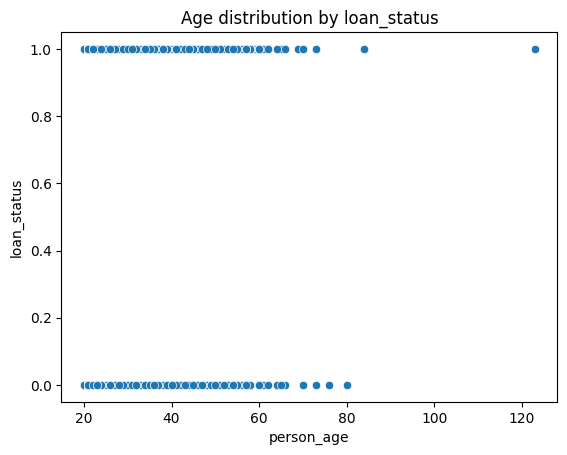

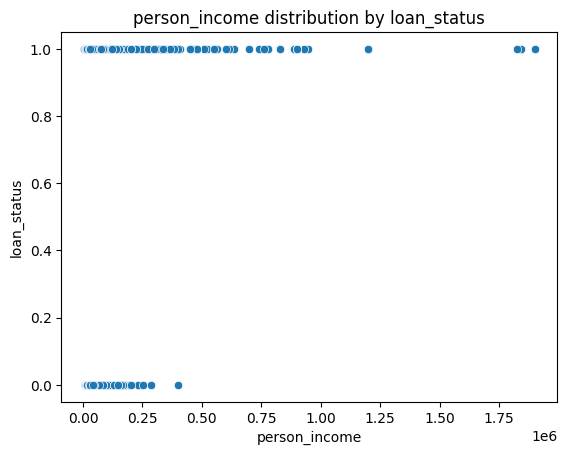

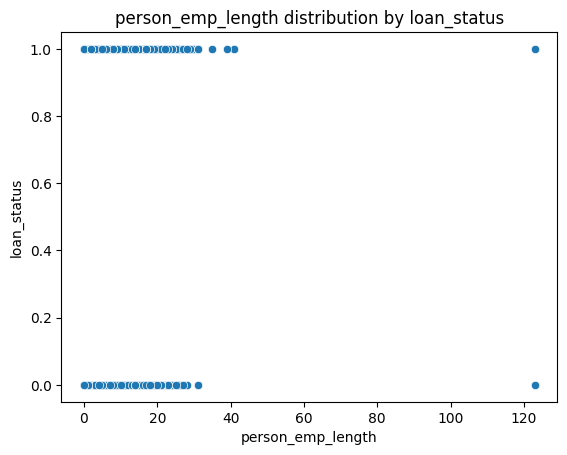

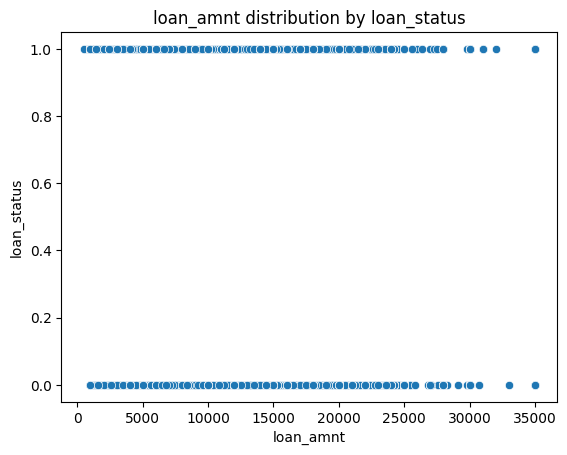

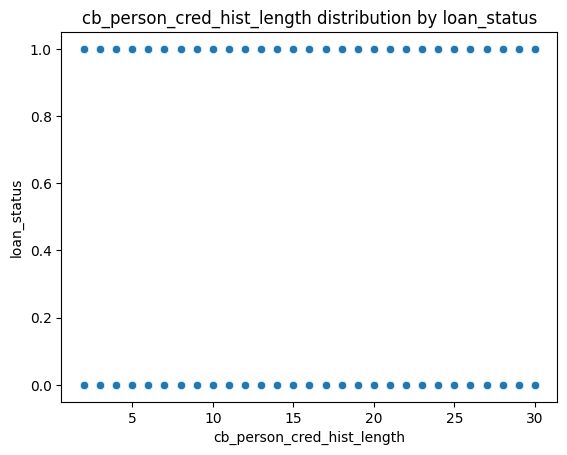

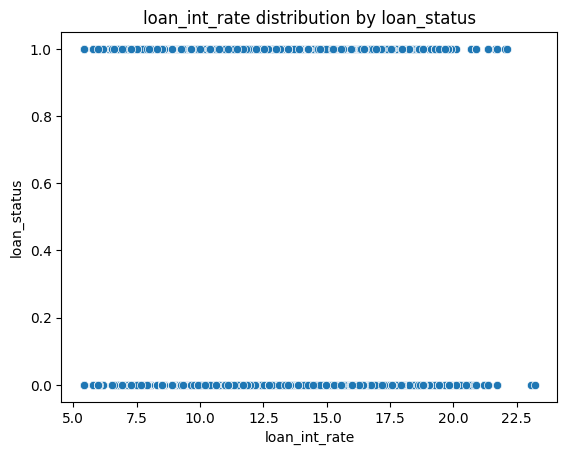

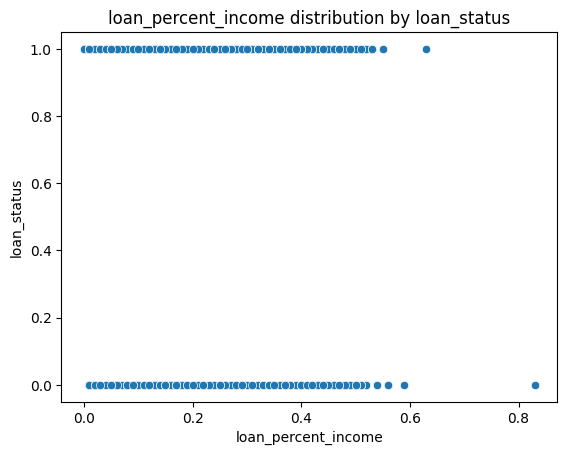

In [36]:
# lets visualize continuous values 
sns.scatterplot(data=train_df, x='person_age', y='loan_status')
plt.title("Age distribution by loan_status")
plt.show()

sns.scatterplot(data=train_df, x='person_income', y='loan_status')
plt.title("person_income distribution by loan_status")
plt.show()

sns.scatterplot(data=train_df, x='person_emp_length', y='loan_status')
plt.title("person_emp_length distribution by loan_status")
plt.show()

sns.scatterplot(data=train_df, x='loan_amnt', y='loan_status')
plt.title("loan_amnt distribution by loan_status")
plt.show()

sns.scatterplot(data=train_df, x='cb_person_cred_hist_length', y='loan_status')
plt.title("cb_person_cred_hist_length distribution by loan_status")
plt.show()

sns.scatterplot(data=train_df, x='loan_int_rate', y='loan_status')
plt.title("loan_int_rate distribution by loan_status")
plt.show()

sns.scatterplot(data=train_df, x='loan_percent_income', y='loan_status')
plt.title("loan_percent_income distribution by loan_status")
plt.show()

# temp = train_df
# temp = temp.drop('person_home_ownership', axis=1)
# temp = temp.drop('loan_intent', axis=1)
# temp = temp.drop('loan_grade', axis=1)
# temp = temp.drop('cb_person_default_on_file', axis=1)
# #print(temp.columns.values)
# pca = PCA(n_components=2)
# components = pca.fit_transform(temp)

# df_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])
# sns.scatterplot(x='PC1', y='PC2', data=df_pca)
# plt.title('PCA Plot to Detect Clusters')
# plt.show()

In [37]:
def check_equal(col1, col2, col3):
    same_value = 0
    zero_value = 0
    value_present = 0
    for index, row in train_df.iterrows():
        value_computed = 0
        if not (row[col3] == 0):
            value_computed = (row[col2]/row[col3])*100
            if (round(value_computed,0) == round(row[col1]*100, 2)):
                same_value += 1
            # else:
            #     print(f"Value computed: {value_computed} and real value in colum: {row[col1]}")
        else:
            zero_value += 1
            if (row[col1] > 0):
                value_present += 1

    print(f"Number of records that have same value: {same_value} out of {train_df.shape[0]} and percentage: {(same_value/train_df.shape[0])*100}")
    print(f"Number of records where {col3} have value zero: {zero_value} but value for col: {col1} is there: {value_present}")

check_equal('loan_percent_income', 'loan_amnt', 'person_income')


Number of records that have same value: 52319 out of 58645 and percentage: 89.21306164208373
Number of records where person_income have value zero: 0 but value for col: loan_percent_income is there: 0


In [38]:
# Which continuous feature is more correlated
from scipy.stats import pointbiserialr

corr, p_value = pointbiserialr(train_df['loan_percent_income'], train_df['loan_status'])
print("For loan_percent_income Correlation:", corr)
corr, p_value1 = pointbiserialr(train_df['loan_amnt'], train_df['loan_status'])
print("For loan_amnt Correlation:", corr)
corr, p_value2 = pointbiserialr(train_df['person_income'], train_df['loan_status'])
print("For person_income Correlation:", corr)
corr, p_value2 = pointbiserialr(train_df['person_age'], train_df['loan_status'])
print("For person_age Correlation:", corr)
corr, p_value2 = pointbiserialr(train_df['person_emp_length'], train_df['loan_status'])
print("For person_emp_length Correlation:", corr)
corr, p_value2 = pointbiserialr(train_df['cb_person_cred_hist_length'], train_df['loan_status'])
print("For cb_person_cred_hist_length Correlation:", corr)
corr, p_value2 = pointbiserialr(train_df['loan_int_rate'], train_df['loan_status'])
print("For loan_int_rate Correlation:", corr)

For loan_percent_income Correlation: -0.3782796969360416
For loan_amnt Correlation: -0.14498237026521016
For person_income Correlation: 0.16995618601375628
For person_age Correlation: 0.001129548189087269
For person_emp_length Correlation: 0.1004282702155635
For cb_person_cred_hist_length Correlation: 0.003030094545009851
For loan_int_rate Correlation: -0.3389476721847755


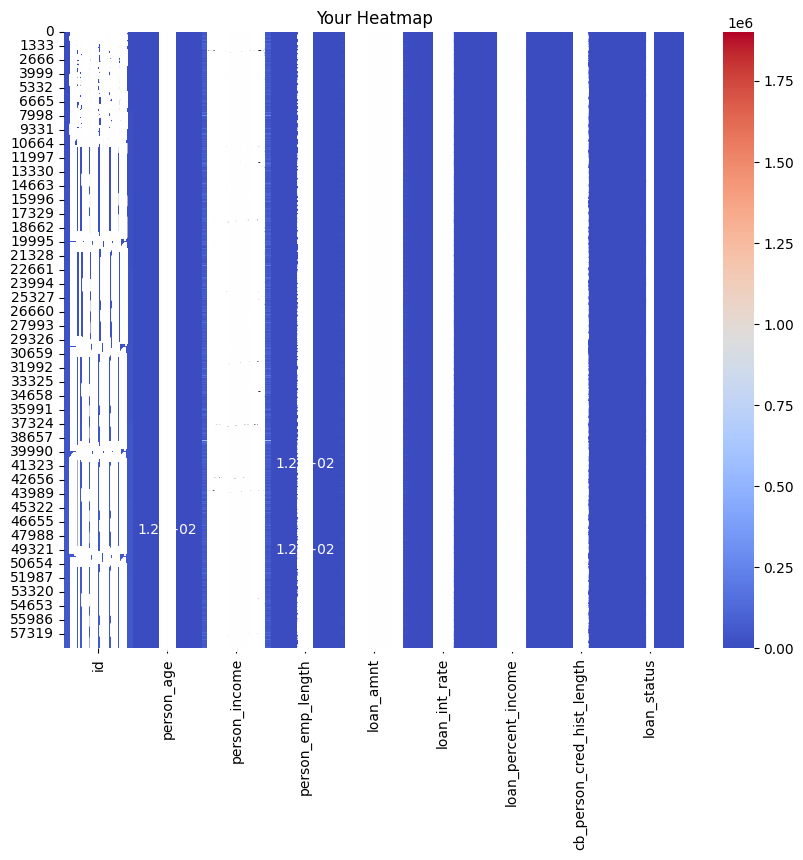

In [39]:
# heat map
temp = train_df
temp = temp.drop('person_home_ownership', axis=1)
temp = temp.drop('loan_intent', axis=1)
temp = temp.drop('loan_grade', axis=1)
temp = temp.drop('cb_person_default_on_file', axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(temp, annot=True, linecolor= 'white', cmap='coolwarm')  # annot=True to show values

plt.title('Your Heatmap')
plt.show()

In [40]:
# check how many records we have with age more than 85
# check how many records we have with person_emp_length more than 50
def count_records(col, capvalue):
    count = 0
    for index, row in train_df.iterrows():
        if (row[col] > capvalue):
            count += 1
            print(f"value: {row[col]} and id: {row['id']}")
    print(f"Number of records for {col} with value more than {capvalue}: {count}")

count_records('person_age', 85)
count_records('person_emp_length', 50)

value: 123 and id: 47336
Number of records for person_age with value more than 85: 1
value: 123.0 and id: 41079
value: 123.0 and id: 49252
Number of records for person_emp_length with value more than 50: 2


# Data Preprocessing

In [41]:
# remove the outlier data
print(train_df.shape)
train_df = train_df[train_df['person_age']<=85]
train_df = train_df[train_df['person_age']>0]
train_df = train_df[train_df['person_emp_length']<=50]
train_df = train_df[train_df['person_income']<=1000000]
print(train_df.shape)

(58645, 13)
(58637, 13)


In [42]:
# original features
org_traindf = train_df
org_traindf = org_traindf.drop("id", axis=1)
org_traindf['loan_grade'] = org_traindf['loan_grade'].astype('category').cat.codes
org_traindf['person_home_ownership'] = org_traindf['person_home_ownership'].astype('category').cat.codes
org_traindf['loan_intent'] = org_traindf['loan_intent'].astype('category').cat.codes
org_traindf['cb_person_default_on_file'] = org_traindf['cb_person_default_on_file'].astype('category').cat.codes

## Feature Engineering

In [43]:
def create_features(df):
    # Your existing features
    df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']
    df['income_times_emp_len'] = df['person_income'] * df['person_emp_length']
    df['cred_hist_per_year_employed'] = df['cb_person_cred_hist_length'] / (df['person_emp_length'] + 1)
    
    df['income_per_age'] = df['person_income'] / df['person_age']
    df['total_debt_burden'] = df['loan_amnt'] * df['loan_int_rate']
    df['employment_stability'] = df['person_emp_length'] / df['person_age']
    df['risk_score'] = df['loan_int_rate'] * df['loan_amnt'] / df['person_income']
    
    return df

train_df = create_features(train_df)

In [44]:
# make person_age into categorical bins
temp = 0
age = []
for index, row in train_df.iterrows():
    temp = row['person_age']
    if temp > 0 and temp < 25:
        age.append('child')
    elif temp >= 25 and temp < 35:
        age.append('youth')
    elif temp >= 35 and temp < 50:
        age.append('middleage')
    elif temp >= 50 and temp <= 85:
        age.append('oldage')
    else:
        print(temp)
train_df['age'] = age

## Feature Scaling

In [45]:
scaler = skl.preprocessing.StandardScaler()
train_df['person_emp_length'] = scaler.fit_transform(train_df[['person_emp_length']])
train_df['loan_percent_income'] = scaler.fit_transform(train_df[['loan_percent_income']])
train_df['loan_amnt'] = scaler.fit_transform(train_df[['loan_amnt']])
train_df['loan_int_rate'] = scaler.fit_transform(train_df[['loan_int_rate']])
train_df['cb_person_cred_hist_length'] = scaler.fit_transform(train_df[['cb_person_cred_hist_length']])

# Scale new features
train_df['income_per_age'] = scaler.fit_transform(train_df[['income_per_age']])
train_df['total_debt_burden'] = scaler.fit_transform(train_df[['total_debt_burden']])
train_df['employment_stability'] = scaler.fit_transform(train_df[['employment_stability']])
train_df['risk_score'] = scaler.fit_transform(train_df[['risk_score']])

## Feature Encoding

In [46]:
loan_grade_map={
    'A': 7,
    'B': 6,
    'C': 5,
    'D': 4,
    'E': 3,
    'F': 2,
    'G': 1
}

train_df['loan_grade'] = train_df['loan_grade'].map(loan_grade_map)
train_df['person_home_ownership'] = train_df['person_home_ownership'].astype('category').cat.codes
train_df['loan_intent'] = train_df['loan_intent'].astype('category').cat.codes
train_df['cb_person_default_on_file'] = train_df['cb_person_default_on_file'].astype('category').cat.codes
train_df['age'] = train_df['age'].astype('category').cat.codes

## Feature Removal

In [47]:
train_df = train_df.drop(columns=["loan_percent_income", "id", "age", "cb_person_default_on_file"], axis=1)
print(train_df.columns.values)

['person_age' 'person_income' 'person_home_ownership' 'person_emp_length'
 'loan_intent' 'loan_grade' 'loan_amnt' 'loan_int_rate'
 'cb_person_cred_hist_length' 'loan_status' 'loan_to_income_ratio'
 'income_times_emp_len' 'cred_hist_per_year_employed' 'income_per_age'
 'total_debt_burden' 'employment_stability' 'risk_score']


## Base Classifier

In [48]:
# Split data
y_train = train_df['loan_status']
x_train= train_df.drop('loan_status', axis=1)
cv = skl.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
org_ytrain = org_traindf['loan_status']
org_xtrain = org_traindf.drop('loan_status', axis=1)
smote = SMOTE(random_state=42, sampling_strategy=0.7)

## Logistic Regression

In [49]:
# Logistic regression with engineered data

lr = skl.linear_model.LogisticRegression()
pipeline = Pipeline([
    ('smote', smote),
    ('model', lr)
])
y_pred = skl.model_selection.cross_val_predict(pipeline, x_train, y_train, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Logistic Regression for each fold:", results['test_accuracy'])
print("F1 for Logistic Regression for each fold:", results['test_f1'])

print("\nMean accuracy for Logistic Regression:", results['test_accuracy'].mean())
print("Mean F1 for Logistic Regression:", results['test_f1'].mean())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
   

              precision    recall  f1-score   support

    Rejected       0.44      0.69      0.54      8349
    Approved       0.94      0.85      0.90     50288

    accuracy                           0.83     58637
   macro avg       0.69      0.77      0.72     58637
weighted avg       0.87      0.83      0.84     58637



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
   

Accuracy for Logistic Regression for each fold: [0.82972374 0.83142906 0.82996504 0.83516671 0.82527501]
F1 for Logistic Regression for each fold: [0.89578876 0.89682167 0.89582027 0.89938056 0.89277304]

Mean accuracy for Logistic Regression: 0.8303119100742435
Mean F1 for Logistic Regression: 0.896116860477502


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
# Logistic regression with original features

lr = skl.linear_model.LogisticRegression()
pipeline = Pipeline([
    ('smote', smote),
    ('model', lr)
])
y_pred = skl.model_selection.cross_val_predict(pipeline, org_xtrain, org_ytrain, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Logistic Regression for each fold:", results['test_accuracy'])
print("F1 for Logistic Regression for each fold:", results['test_f1'])

print("\nMean accuracy for Logistic Regression:", results['test_accuracy'].mean())
print("Mean F1 for Logistic Regression:", results['test_f1'].mean())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
   

              precision    recall  f1-score   support

    Rejected       0.40      0.73      0.52      8349
    Approved       0.95      0.82      0.88     50288

    accuracy                           0.81     58637
   macro avg       0.67      0.77      0.70     58637
weighted avg       0.87      0.81      0.83     58637



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
   

Accuracy for Logistic Regression for each fold: [0.82972374 0.83142906 0.82996504 0.83516671 0.82527501]
F1 for Logistic Regression for each fold: [0.89578876 0.89682167 0.89582027 0.89938056 0.89277304]

Mean accuracy for Logistic Regression: 0.8303119100742435
Mean F1 for Logistic Regression: 0.896116860477502


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## RandomForest Classifier with SMOTE

In [52]:
# Random Forest Classifier with engineered data

rf = skl.ensemble.RandomForestClassifier(
    n_estimators=100,   # number of trees
    random_state=42
)
pipeline = Pipeline([
    ('smote', smote),
    ('model', rf)
])
y_pred = skl.model_selection.cross_val_predict(pipeline, x_train, y_train, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Random Forest for each fold:", results['test_accuracy'])
print("F1 for Random Forest for each fold:", results['test_f1'])

print("\nMean accuracy for Random Forest:", results['test_accuracy'].mean())
print("Mean F1 for Random Forest:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.75      0.74      0.74      8349
    Approved       0.96      0.96      0.96     50288

    accuracy                           0.93     58637
   macro avg       0.85      0.85      0.85     58637
weighted avg       0.93      0.93      0.93     58637

Accuracy for Random Forest for each fold: [0.92598909 0.92957026 0.93075808 0.92785879 0.92538586]
F1 for Random Forest for each fold: [0.95697006 0.95906433 0.95974219 0.95796064 0.95652606]

Mean accuracy for Random Forest: 0.9279124147805039
Mean F1 for Random Forest: 0.9580526559786702


In [53]:
# Random Forest Classifier with original features

rf = skl.ensemble.RandomForestClassifier(
    n_estimators=100,   # number of trees
    random_state=42
)
pipeline = Pipeline([
    ('smote', smote),
    ('model', rf)
])
y_pred = skl.model_selection.cross_val_predict(pipeline, org_xtrain, org_ytrain, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Random Forest for each fold:", results['test_accuracy'])
print("F1 for Random Forest for each fold:", results['test_f1'])

print("\nMean accuracy for Random Forest:", results['test_accuracy'].mean())
print("Mean F1 for Random Forest:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.78      0.74      0.76      8349
    Approved       0.96      0.96      0.96     50288

    accuracy                           0.93     58637
   macro avg       0.87      0.85      0.86     58637
weighted avg       0.93      0.93      0.93     58637

Accuracy for Random Forest for each fold: [0.92598909 0.92957026 0.93075808 0.92785879 0.92538586]
F1 for Random Forest for each fold: [0.95697006 0.95906433 0.95974219 0.95796064 0.95652606]

Mean accuracy for Random Forest: 0.9279124147805039
Mean F1 for Random Forest: 0.9580526559786702


## RandomForest Classifier with Class Weights

In [54]:
# Random Forest Classifier with engineered data

rf = skl.ensemble.RandomForestClassifier(
    n_estimators=100,   # number of trees
    random_state=42,
    class_weight={0: 3.75, 1: 1}
)

y_pred = skl.model_selection.cross_val_predict(rf, x_train, y_train, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(rf, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Random Forest for each fold:", results['test_accuracy'])
print("F1 for Random Forest for each fold:", results['test_f1'])

print("\nMean accuracy for Random Forest:", results['test_accuracy'].mean())
print("Mean F1 for Random Forest:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.92      0.68      0.78      8349
    Approved       0.95      0.99      0.97     50288

    accuracy                           0.95     58637
   macro avg       0.94      0.83      0.88     58637
weighted avg       0.95      0.95      0.94     58637

Accuracy for Random Forest for each fold: [0.9457708  0.94730559 0.9473011  0.94653364 0.94491345]
F1 for Random Forest for each fold: [0.96905411 0.9699796  0.9699504  0.9694846  0.96854611]

Mean accuracy for Random Forest: 0.9463649172610495
Mean F1 for Random Forest: 0.9694029627923489


In [55]:
# Random Forest Classifier with original features

rf = skl.ensemble.RandomForestClassifier(
    n_estimators=100,   # number of trees
    random_state=42,
    class_weight={0: 3.75, 1: 1}
)

y_pred = skl.model_selection.cross_val_predict(rf, org_xtrain, org_ytrain, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(rf, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Random Forest for each fold:", results['test_accuracy'])
print("F1 for Random Forest for each fold:", results['test_f1'])

print("\nMean accuracy for Random Forest:", results['test_accuracy'].mean())
print("Mean F1 for Random Forest:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.93      0.69      0.79      8349
    Approved       0.95      0.99      0.97     50288

    accuracy                           0.95     58637
   macro avg       0.94      0.84      0.88     58637
weighted avg       0.95      0.95      0.95     58637

Accuracy for Random Forest for each fold: [0.9457708  0.94730559 0.9473011  0.94653364 0.94491345]
F1 for Random Forest for each fold: [0.96905411 0.9699796  0.9699504  0.9694846  0.96854611]

Mean accuracy for Random Forest: 0.9463649172610495
Mean F1 for Random Forest: 0.9694029627923489


## LightGBM Classifier with SMOTE

In [56]:
# LightGBM Classifier with engineered data

lgbm = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.03,
    num_leaves=50,
    max_depth=10,
    min_child_samples=20,
    random_state=42,
    verbose=-1
)
pipeline = Pipeline([
    ('smote', smote),
    ('model', rf)
])
y_pred = skl.model_selection.cross_val_predict(pipeline, x_train, y_train, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for LightGBM for each fold:", results['test_accuracy'])
print("F1 for LightGBM for each fold:", results['test_f1'])

print("\nMean accuracy for LightGBM:", results['test_accuracy'].mean())
print("Mean F1 for LightGBM:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.75      0.72      0.74      8349
    Approved       0.95      0.96      0.96     50288

    accuracy                           0.93     58637
   macro avg       0.85      0.84      0.85     58637
weighted avg       0.93      0.93      0.93     58637

Accuracy for LightGBM for each fold: [0.92743861 0.92522169 0.93092863 0.92709133 0.92436258]
F1 for LightGBM for each fold: [0.95788171 0.95658201 0.9599129  0.95756613 0.9559998 ]

Mean accuracy for LightGBM: 0.9270085672328789
Mean F1 for LightGBM: 0.9575885105017476


In [57]:
# LightGBM Classifier with original fetaures

lgbm = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.03,
    num_leaves=50,
    max_depth=10,
    min_child_samples=20,
    random_state=42,
    verbose=-1
)
pipeline = Pipeline([
    ('smote', smote),
    ('model', rf)
])
y_pred = skl.model_selection.cross_val_predict(pipeline, org_xtrain, org_ytrain, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for LightGBM for each fold:", results['test_accuracy'])
print("F1 for LightGBM for each fold:", results['test_f1'])

print("\nMean accuracy for LightGBM:", results['test_accuracy'].mean())
print("Mean F1 for LightGBM:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.79      0.72      0.75      8349
    Approved       0.95      0.97      0.96     50288

    accuracy                           0.93     58637
   macro avg       0.87      0.85      0.86     58637
weighted avg       0.93      0.93      0.93     58637

Accuracy for LightGBM for each fold: [0.92743861 0.92522169 0.93092863 0.92709133 0.92436258]
F1 for LightGBM for each fold: [0.95788171 0.95658201 0.9599129  0.95756613 0.9559998 ]

Mean accuracy for LightGBM: 0.9270085672328789
Mean F1 for LightGBM: 0.9575885105017476


## LightGBM Classifier with Class Weight

In [58]:
# LightGBM Classifier with engineered data

lgbm = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.03,
    num_leaves=50,
    max_depth=10,
    min_child_samples=20,
    class_weight={0: 3.75, 1: 1},
    random_state=42,
    verbose=-1
)
y_pred = skl.model_selection.cross_val_predict(lgbm, x_train, y_train, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(lgbm, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for LightGBM for each fold:", results['test_accuracy'])
print("F1 for LightGBM for each fold:", results['test_f1'])

print("\nMean accuracy for LightGBM:", results['test_accuracy'].mean())
print("Mean F1 for LightGBM:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.81      0.78      0.80      8349
    Approved       0.96      0.97      0.97     50288

    accuracy                           0.94     58637
   macro avg       0.89      0.87      0.88     58637
weighted avg       0.94      0.94      0.94     58637

Accuracy for LightGBM for each fold: [0.94108117 0.9457708  0.94704528 0.94022342 0.94133197]
F1 for LightGBM for each fold: [0.965787   0.96853666 0.96927416 0.96518846 0.96586963]

Mean accuracy for LightGBM: 0.9430905286607288
Mean F1 for LightGBM: 0.9669311804893942


In [59]:
# LightGBM Classifier with original fetaures

lgbm = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.03,
    num_leaves=50,
    max_depth=10,
    min_child_samples=20,
    class_weight={0: 3.75, 1: 1},
    random_state=42,
    verbose=-1
)
y_pred = skl.model_selection.cross_val_predict(lgbm, org_xtrain, org_ytrain, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(lgbm, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for LightGBM for each fold:", results['test_accuracy'])
print("F1 for LightGBM for each fold:", results['test_f1'])

print("\nMean accuracy for LightGBM:", results['test_accuracy'].mean())
print("Mean F1 for LightGBM:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.81      0.80      0.80      8349
    Approved       0.97      0.97      0.97     50288

    accuracy                           0.94     58637
   macro avg       0.89      0.88      0.88     58637
weighted avg       0.94      0.94      0.94     58637

Accuracy for LightGBM for each fold: [0.94108117 0.9457708  0.94704528 0.94022342 0.94133197]
F1 for LightGBM for each fold: [0.965787   0.96853666 0.96927416 0.96518846 0.96586963]

Mean accuracy for LightGBM: 0.9430905286607288
Mean F1 for LightGBM: 0.9669311804893942


## Feature Importance Values

In [60]:
lgbm1 = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.03,
    num_leaves=50,
    max_depth=10,
    min_child_samples=20,
    class_weight={0: 3.75, 1: 1},
    random_state=42,
    verbose=-1
)
lgbm1.fit(x_train, y_train)

# Get feature importance
feature_imp = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': lgbm1.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_imp['Importance'] = (feature_imp['Importance'] / feature_imp['Importance'].sum()) * 100
feature_imp = feature_imp.sort_values(by='Importance', ascending=False)
print(feature_imp)

                        Feature  Importance
1                 person_income   16.959184
7                 loan_int_rate   10.125364
9          loan_to_income_ratio    8.102041
13            total_debt_burden    7.294461
4                   loan_intent    7.069971
12               income_per_age    6.734694
15                   risk_score    6.693878
11  cred_hist_per_year_employed    6.352770
10         income_times_emp_len    5.772595
14         employment_stability    5.577259
6                     loan_amnt    4.609329
0                    person_age    4.320700
2         person_home_ownership    3.988338
8    cb_person_cred_hist_length    2.603499
5                    loan_grade    1.956268
3             person_emp_length    1.839650


## Catboost with SMOTE

In [61]:
# Catboost with engineered data

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    verbose=0,
    random_seed=42
)
pipeline = Pipeline([
    ('smote', smote),
    ('model', cat_model)
])
y_pred = skl.model_selection.cross_val_predict(pipeline, x_train, y_train, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Catboost for each fold:", results['test_accuracy'])
print("F1 for Catboost for each fold:", results['test_f1'])

print("\nMean accuracy for Catboost:", results['test_accuracy'].mean())
print("Mean F1 for Catboost:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.86      0.73      0.79      8349
    Approved       0.96      0.98      0.97     50288

    accuracy                           0.95     58637
   macro avg       0.91      0.86      0.88     58637
weighted avg       0.94      0.95      0.94     58637

Accuracy for Catboost for each fold: [0.94449181 0.94722033 0.94559563 0.94465763 0.94533981]
F1 for Catboost for each fold: [0.96806475 0.96961665 0.96866097 0.96811594 0.96848419]

Mean accuracy for Catboost: 0.9454610435381277
Mean F1 for Catboost: 0.9685885013204153


In [62]:
# Catboost with original features

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    verbose=0,
    random_seed=42
)
pipeline = Pipeline([
    ('smote', smote),
    ('model', cat_model)
])
y_pred = skl.model_selection.cross_val_predict(pipeline, org_xtrain, org_ytrain, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Catboost for each fold:", results['test_accuracy'])
print("F1 for Catboost for each fold:", results['test_f1'])

print("\nMean accuracy for Catboost:", results['test_accuracy'].mean())
print("Mean F1 for Catboost:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.90      0.73      0.81      8349
    Approved       0.96      0.99      0.97     50288

    accuracy                           0.95     58637
   macro avg       0.93      0.86      0.89     58637
weighted avg       0.95      0.95      0.95     58637

Accuracy for Catboost for each fold: [0.94449181 0.94722033 0.94559563 0.94465763 0.94533981]
F1 for Catboost for each fold: [0.96806475 0.96961665 0.96866097 0.96811594 0.96848419]

Mean accuracy for Catboost: 0.9454610435381277
Mean F1 for Catboost: 0.9685885013204153


## Catboost with Class Weight

In [64]:
# Catboost with engineered data

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    class_weights={0: 3.75, 1: 1},
    verbose=0,
    random_seed=42
)

y_pred = skl.model_selection.cross_val_predict(cat_model, x_train, y_train, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(cat_model, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Catboost for each fold:", results['test_accuracy'])
print("F1 for Catboost for each fold:", results['test_f1'])

print("\nMean accuracy for Catboost:", results['test_accuracy'].mean())
print("Mean F1 for Catboost:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.80      0.79      0.79      8349
    Approved       0.96      0.97      0.97     50288

    accuracy                           0.94     58637
   macro avg       0.88      0.88      0.88     58637
weighted avg       0.94      0.94      0.94     58637

Accuracy for Catboost for each fold: [0.93980218 0.94398022 0.94465763 0.93979705 0.93766522]
F1 for Catboost for each fold: [0.96499058 0.96738969 0.96781233 0.96493494 0.96361193]

Mean accuracy for Catboost: 0.9411804590705024
Mean F1 for Catboost: 0.9657478912758297


In [65]:
# Catboost with original features

cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    class_weights={0: 3.75, 1: 1},
    verbose=0,
    random_seed=42
)

y_pred = skl.model_selection.cross_val_predict(cat_model, org_xtrain, org_ytrain, cv=cv)
print(skl.metrics.classification_report(y_train, y_pred, target_names=['Rejected', 'Approved']))

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}
# Get results for each fold
results = skl.model_selection.cross_validate(cat_model, x_train, y_train, cv=cv, scoring=scoring)
print("Accuracy for Catboost for each fold:", results['test_accuracy'])
print("F1 for Catboost for each fold:", results['test_f1'])

print("\nMean accuracy for Catboost:", results['test_accuracy'].mean())
print("Mean F1 for Catboost:", results['test_f1'].mean())

              precision    recall  f1-score   support

    Rejected       0.81      0.79      0.80      8349
    Approved       0.97      0.97      0.97     50288

    accuracy                           0.94     58637
   macro avg       0.89      0.88      0.88     58637
weighted avg       0.94      0.94      0.94     58637

Accuracy for Catboost for each fold: [0.93980218 0.94398022 0.94465763 0.93979705 0.93766522]
F1 for Catboost for each fold: [0.96499058 0.96738969 0.96781233 0.96493494 0.96361193]

Mean accuracy for Catboost: 0.9411804590705024
Mean F1 for Catboost: 0.9657478912758297
